<a href="https://colab.research.google.com/github/kikiru328/CAKD3-Github/blob/main/DL_using_a_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######## module import

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', my_path)
sys.path.insert(0,my_path)


Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,821 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading datab

# Pretrained_ convent

ImageNet 데이터셋에 훈련된 VGG16 네트워크 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다.
keras applicaions 모듈에서 임포트 할 수 있습니다. Keras.applicaions 모듈에서 사용가능한 이미지 분류 모델은 다음과 같습니다
(모두 ImageNet 데이터셋에서 훈련되었습니다)
- Xception
- InceptionV3
- ResNet50
- VGG16
- VGG19
- MobileNet

In [ ]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150,150,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 데이터 증식을 사용하지 않는 빠른 특성 추출

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/CAKD3/Workspace/Keras/dataset/cats_and_dogs_small'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir,'test')

datagen = ImageDataGenerator( rescale = 1./255)
batch_size = 20

# 특징을 추출하는 definition
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'binary'
  )
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : ( i + 1 ) * batch_size] = features_batch
    labels[i * batch_size : ( i + 1 ) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, ( 2000, 4*4*512))
validation_features = np.reshape(validation_features, ( 1000, 4*4*512))
test_features = np.reshape(test_features, (1000,4*4*512))

In [ ]:
train_features.shape

(2000, 8192)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256,activation='relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
              loss = 'binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data = (validation_features, validation_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
100/100 [==============================] - 1s 4ms/step - loss: 0.6061 - acc: 0.6675 - val_loss: 0.4566 - val_acc: 0.8190
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4298 - acc: 0.8080 - val_loss: 0.3727 - val_acc: 0.8440
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3685 - acc: 0.8470 - val_loss: 0.3390 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3253 - acc: 0.8635 - val_loss: 0.3137 - val_acc: 0.8760
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2913 - acc: 0.8790 - val_loss: 0.2872 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2699 - acc: 0.8970 - val_loss: 0.2752 - val_acc: 0.8940
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2577 - acc: 0.8970 - val_loss: 0.2697 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

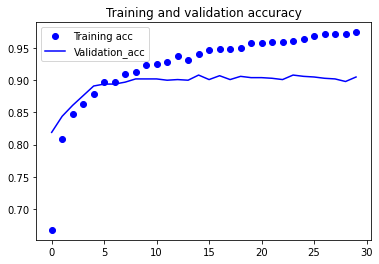

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation_acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()